### DWT-MRA(2D)를 input으로 넣고 2D를 output으로 출력하는 모델
#### Contaminated, Clean Scale을 다르게 함. (각자 scaling)

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pywt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


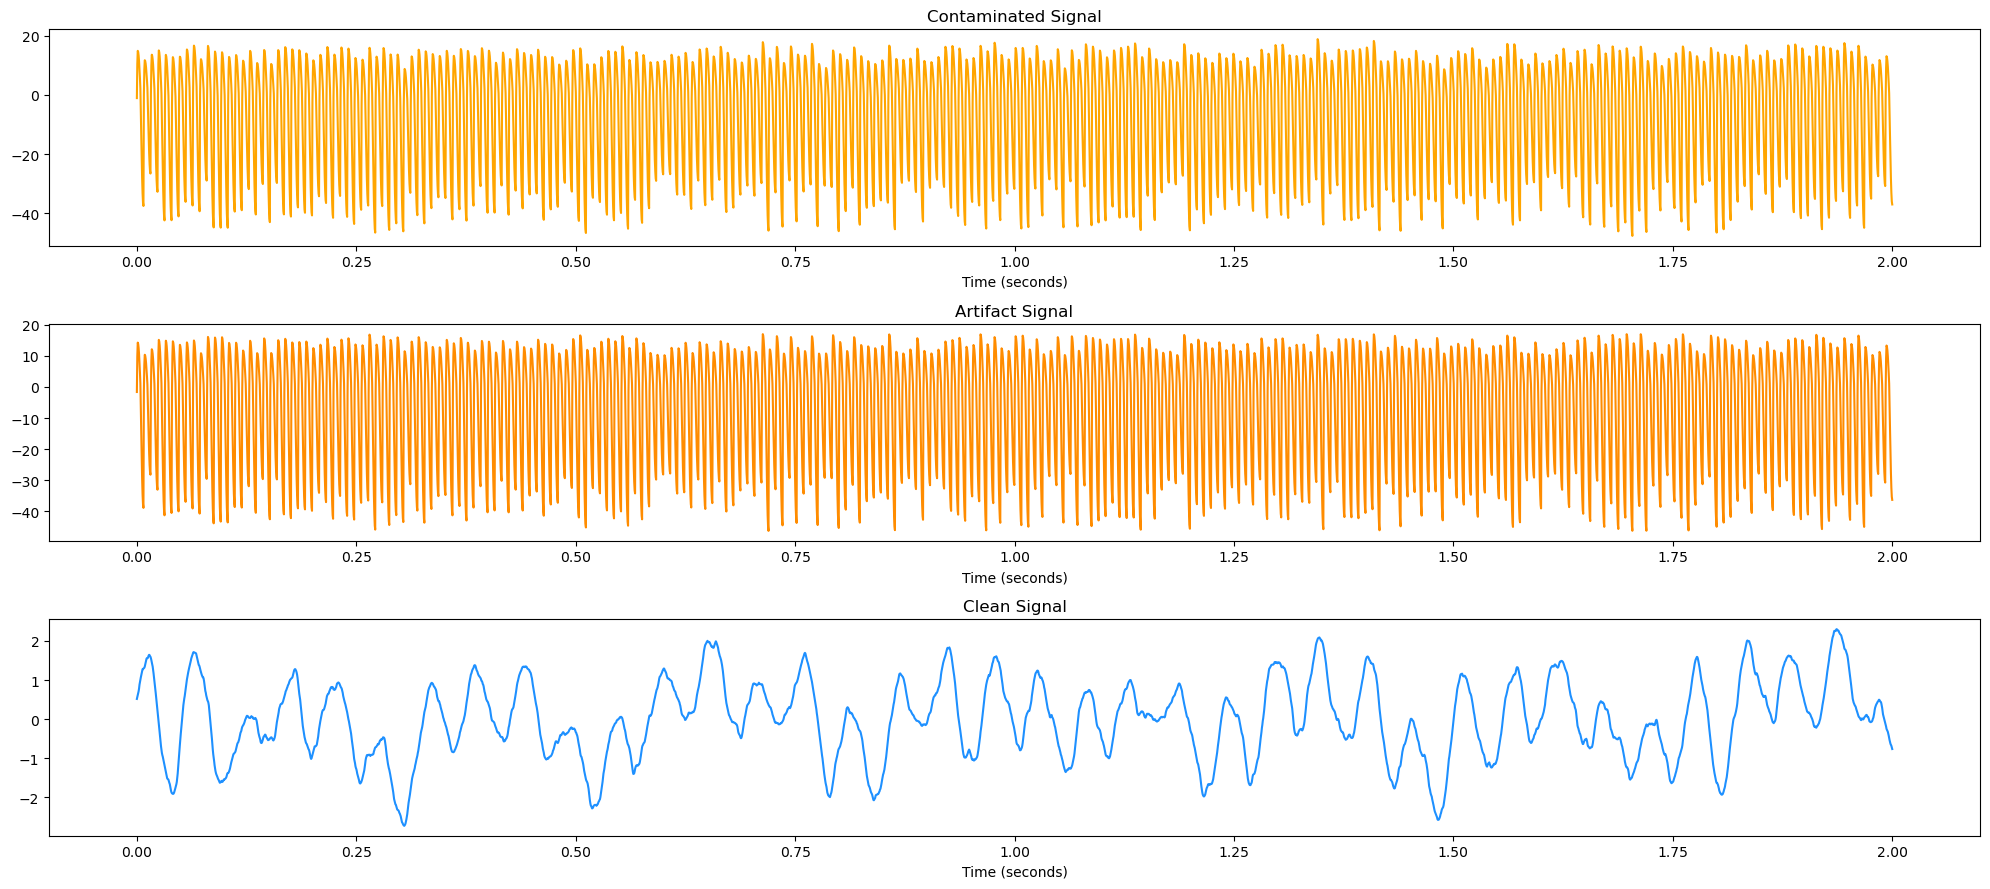

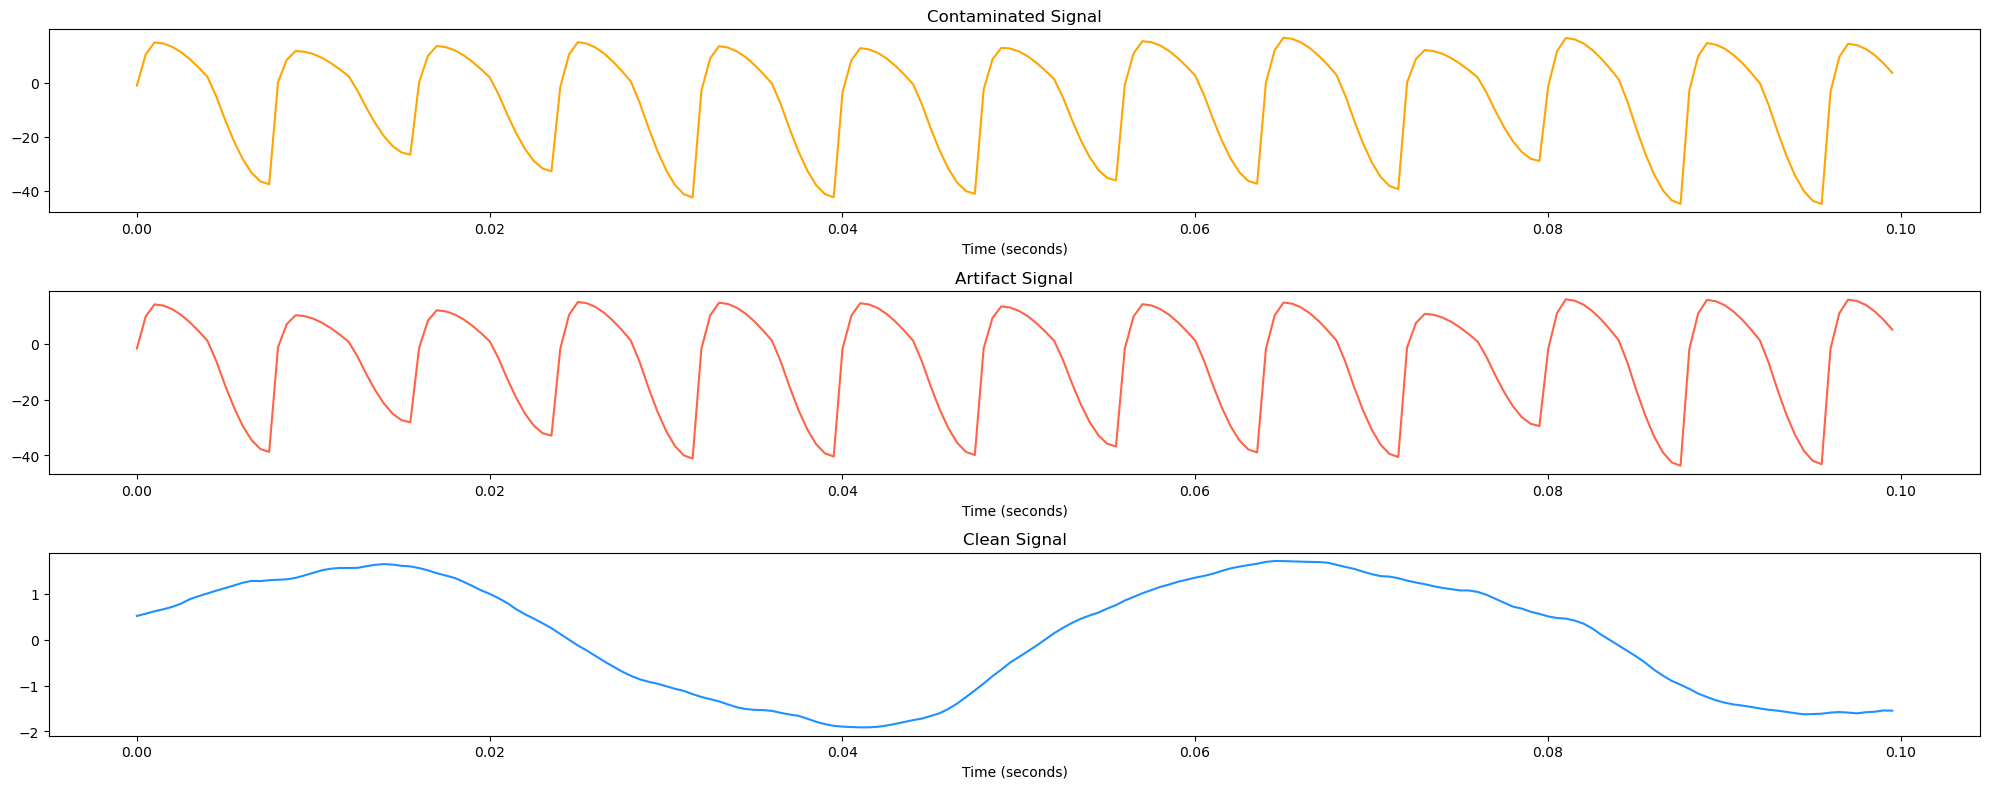

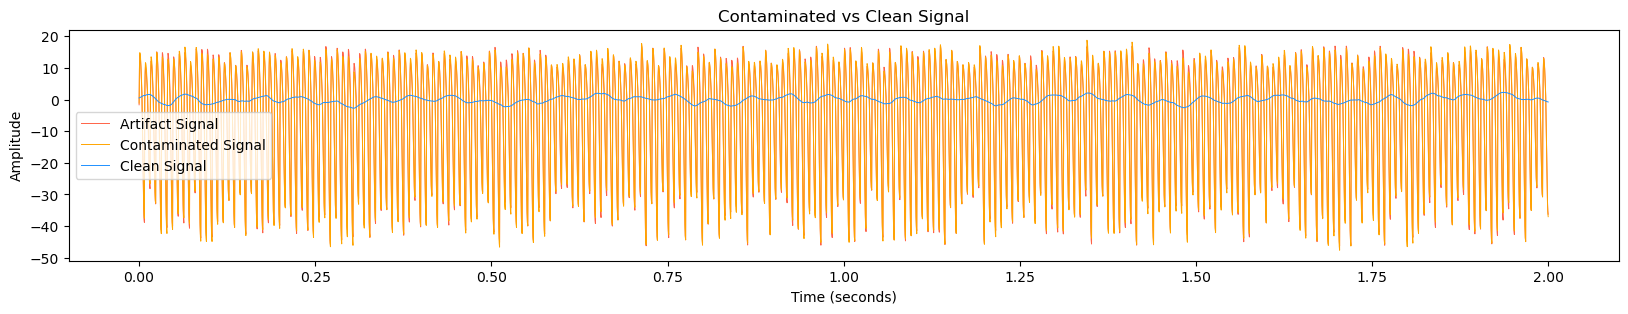

In [17]:
# 데이터 load & plot

import sys
sys.path.append('../../../tool_code/plot/') # "~~/tool_code/plot/" (상대 경로)

from DataLoad import Data_Load_Plot

datapath='../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

Time Domain Error
Mean Absolute Error: 0.0
Mean Squared Error: 0.0


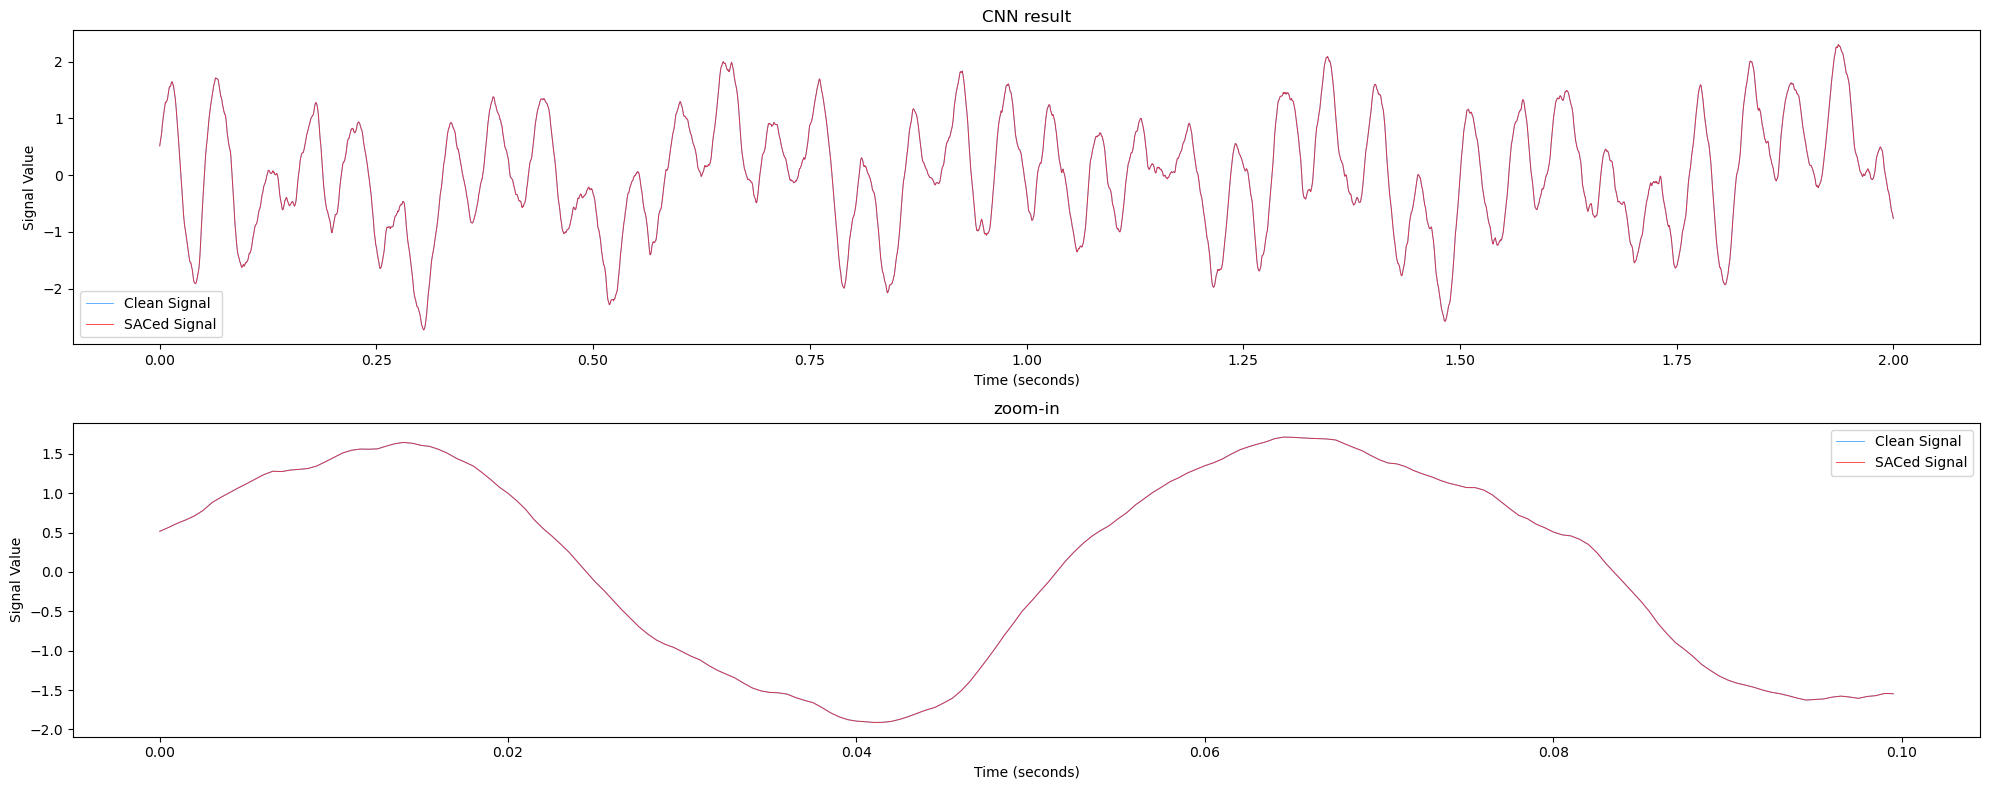

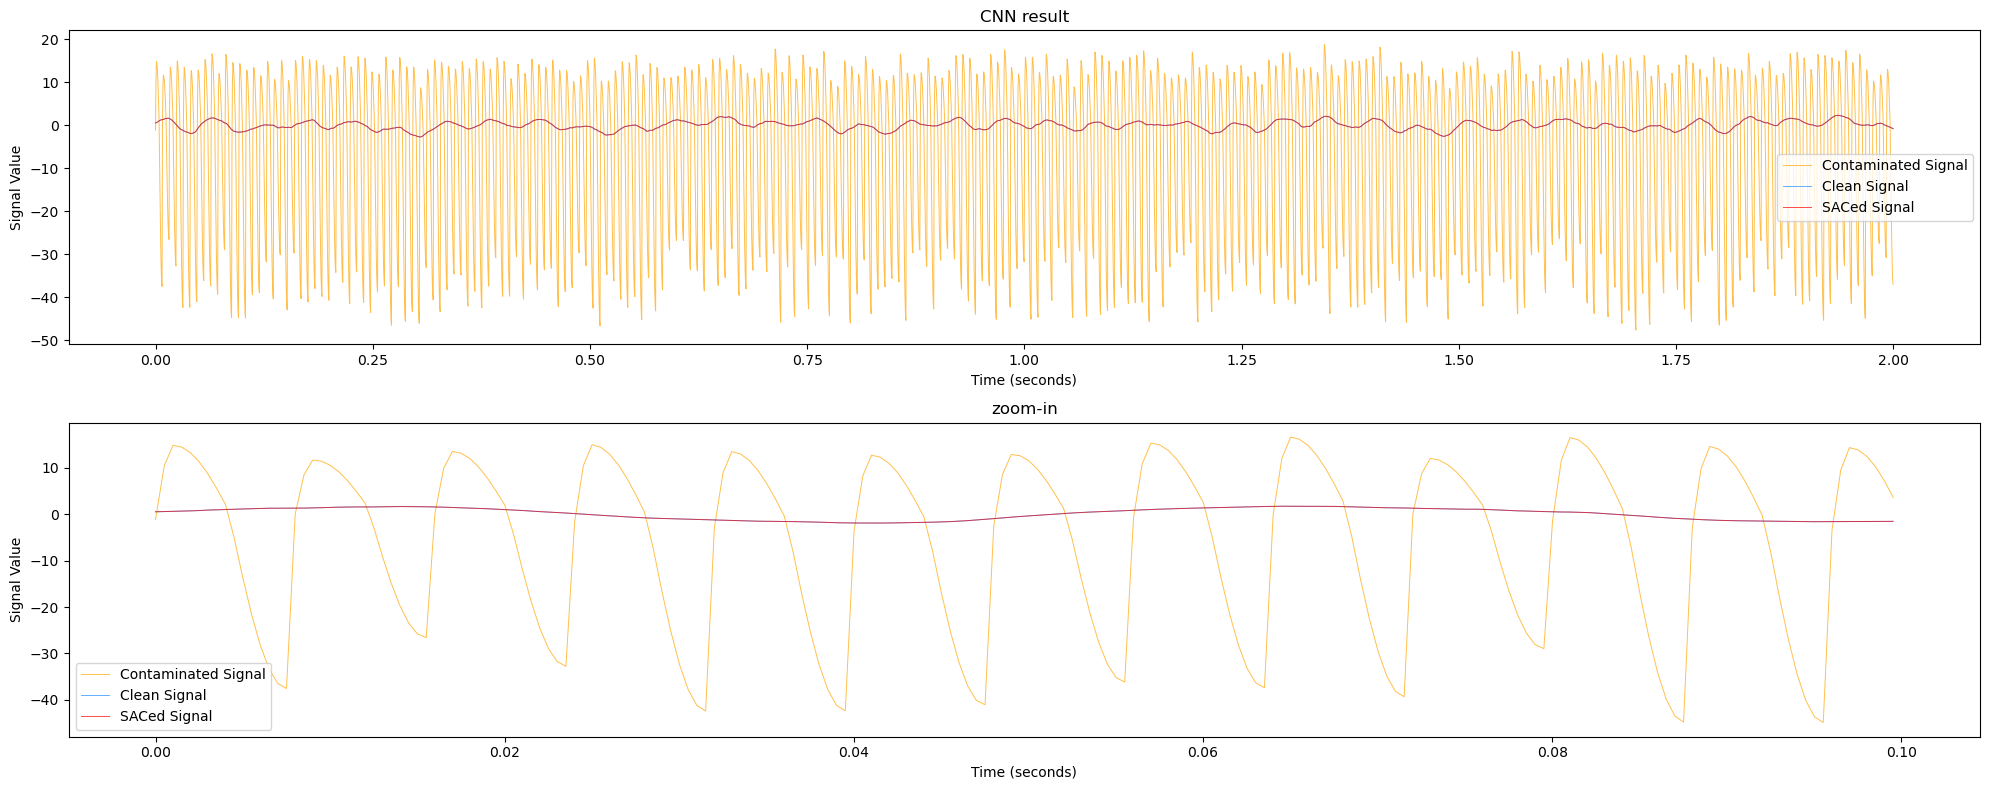

Frequency Domain Error
Mean Absolute Error: 0.0
Mean Squared Error: 0.0


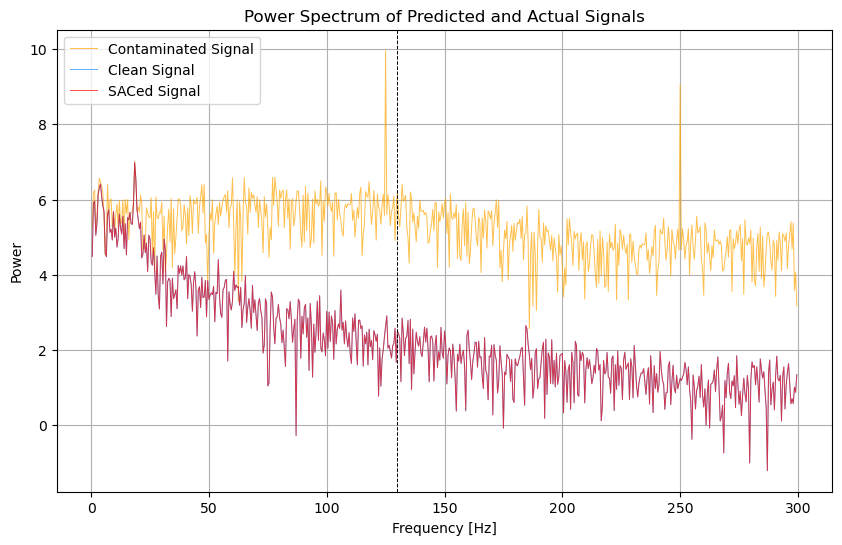

In [33]:
from DataLoad import Result_Plot
Result_Plot(Contaminated_data[0], Clean_data[0], Clean_data[0])

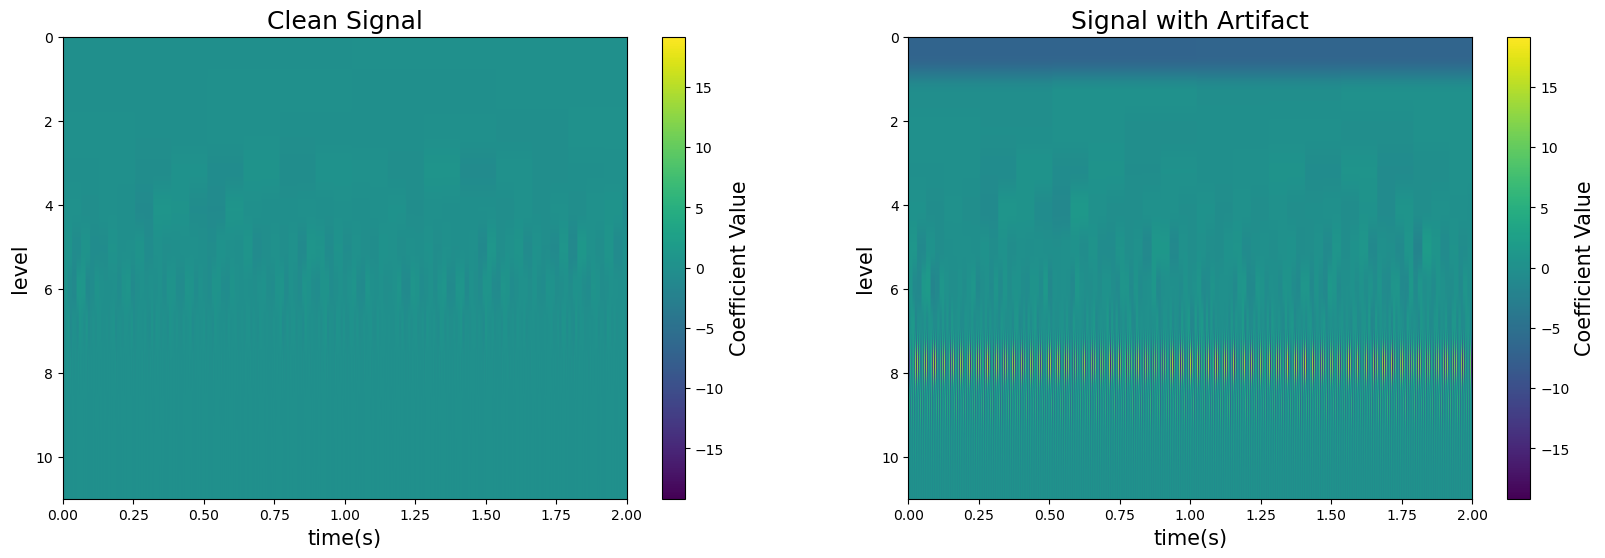

In [18]:
# DWT 수행 (MRA)
wavelet = 'db1'
mra_sig = pywt.mra(Clean_data[0], wavelet, transform='dwt')
mra_art = pywt.mra(Contaminated_data[0], wavelet, transform='dwt')

mra_sig = np.array(mra_sig)
mra_art = np.array(mra_art)

vmin, vmax = min(mra_sig.min(), mra_art.min()), max(mra_sig.max(), mra_art.max())

t = np.linspace(0, 2, num=4000)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.imshow(mra_sig, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean Signal', fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(mra_art, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Signal with Artifact', fontsize=18)

plt.show()

In [19]:
X_wt = []
y_wt = []

wavelet = 'db1'

for x, y in zip(Contaminated_data, Clean_data):
    mra_x = pywt.mra(x, wavelet, transform='dwt')
    mra_y = pywt.mra(y, wavelet, transform='dwt')
    X_wt.append(mra_x)
    y_wt.append(mra_y)

X_wt = np.array(X_wt)
y_wt = np.array(y_wt)

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (1000, 12, 4000)
y_wt: (1000, 12, 4000)


In [20]:
# MRA 결과 scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = []
y = [] 

scaler_x.fit(X_wt[0].flatten().reshape(-1, 1))
scaler_y.fit(y_wt[0].flatten().reshape(-1, 1))

for xx, yy in zip(X_wt, y_wt):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)
    scaled_flat_x = scaler_x.transform(flat_x)
    scaled_flat_y = scaler_y.transform(flat_y) # X, y 각자 scaling
    X.append(scaled_flat_x.reshape(xx.shape))
    y.append(scaled_flat_y.reshape(yy.shape))

X = np.array(X)
y = np.array(y)

print("X:", X.shape)
print("y:", y.shape)

X: (1000, 12, 4000)
y: (1000, 12, 4000)


In [21]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x 1 x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 12, 4000)
y_train shape: (800, 12, 4000)
-----------------------------
X_test shape: (200, 12, 4000)
y_test shape: (200, 12, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 1, 12, 4000)
y_train shape: (800, 12, 4000)
-----------------------------
X_test shape: (200, 1, 12, 4000)
y_test shape: (200, 12, 4000)
-----------------------------


In [22]:
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(CNN2D, self).__init__()
        
        # Encoding path
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoding path
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = nn.Conv2d(64, out_channels, kernel_size=1)

        self.gelu = nn.GELU()
        
    def forward(self, x):
        # Encoding
        x1 = self.gelu(self.conv1(x))
        x2 = self.pool(self.gelu(self.conv2(x1)))
        x3 = self.pool(self.gelu(self.conv3(x2)))
        
        # Decoding
        x3_up = self.upconv3(x3)
        x2_up = self.upconv2(x3_up)
        x_out = self.upconv1(x2_up)
        
        return x_out

In [23]:
num_samples = 4000
height = 12
width = 2000

model = CNN2D().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# 모델 학습
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

Epoch [1/50], Loss: 0.9161054682731629
Epoch [2/50], Loss: 0.5599105453491211


KeyboardInterrupt: 

In [25]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y = y.reshape(y.shape[0], 1, y.shape[1], y.shape[2])
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.4310


Mean Absolute Error: 0.47193384170532227
Mean Squared Error: 0.40842416882514954


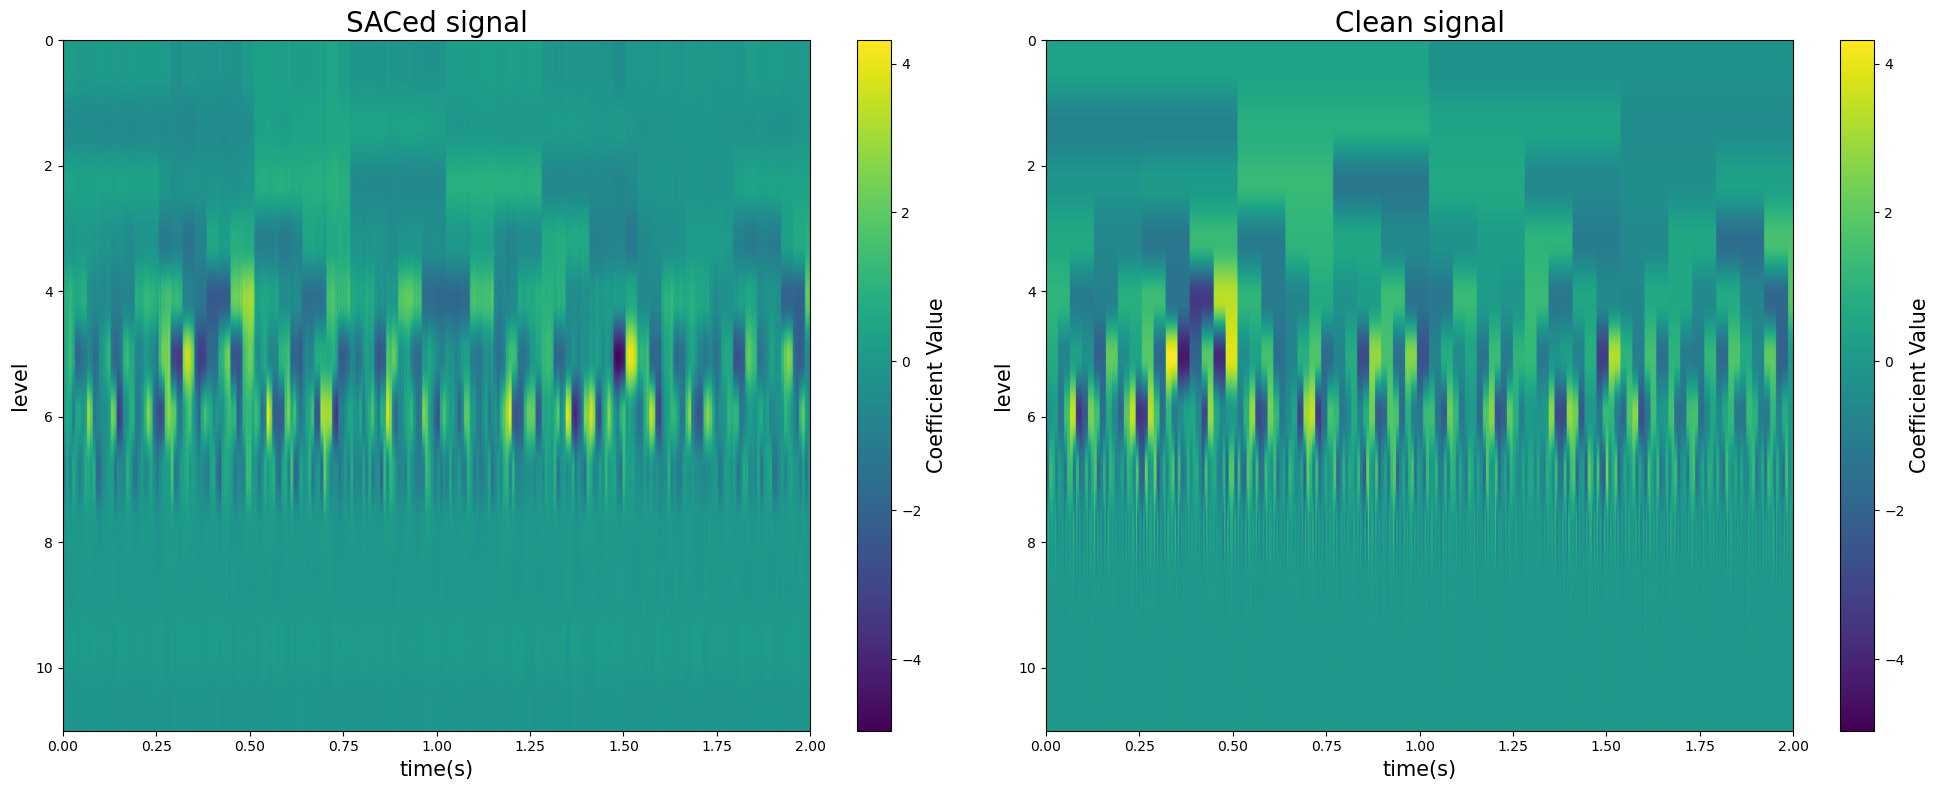

In [26]:
SACed_ex = SACed[0].detach().cpu()
Clean_ex = Clean[0].detach().cpu()

vmin, vmax = min(SACed_ex.min(), Clean_ex.min()), max(SACed_ex.max(), Clean_ex.max())

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(SACed_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('SACed signal', fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(Clean_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean signal', fontsize=20)

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_ex, SACed_ex)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_ex, SACed_ex)}")

Time Domain Error
Mean Absolute Error: 0.3031429708871214
Mean Squared Error: 0.1467847498911296


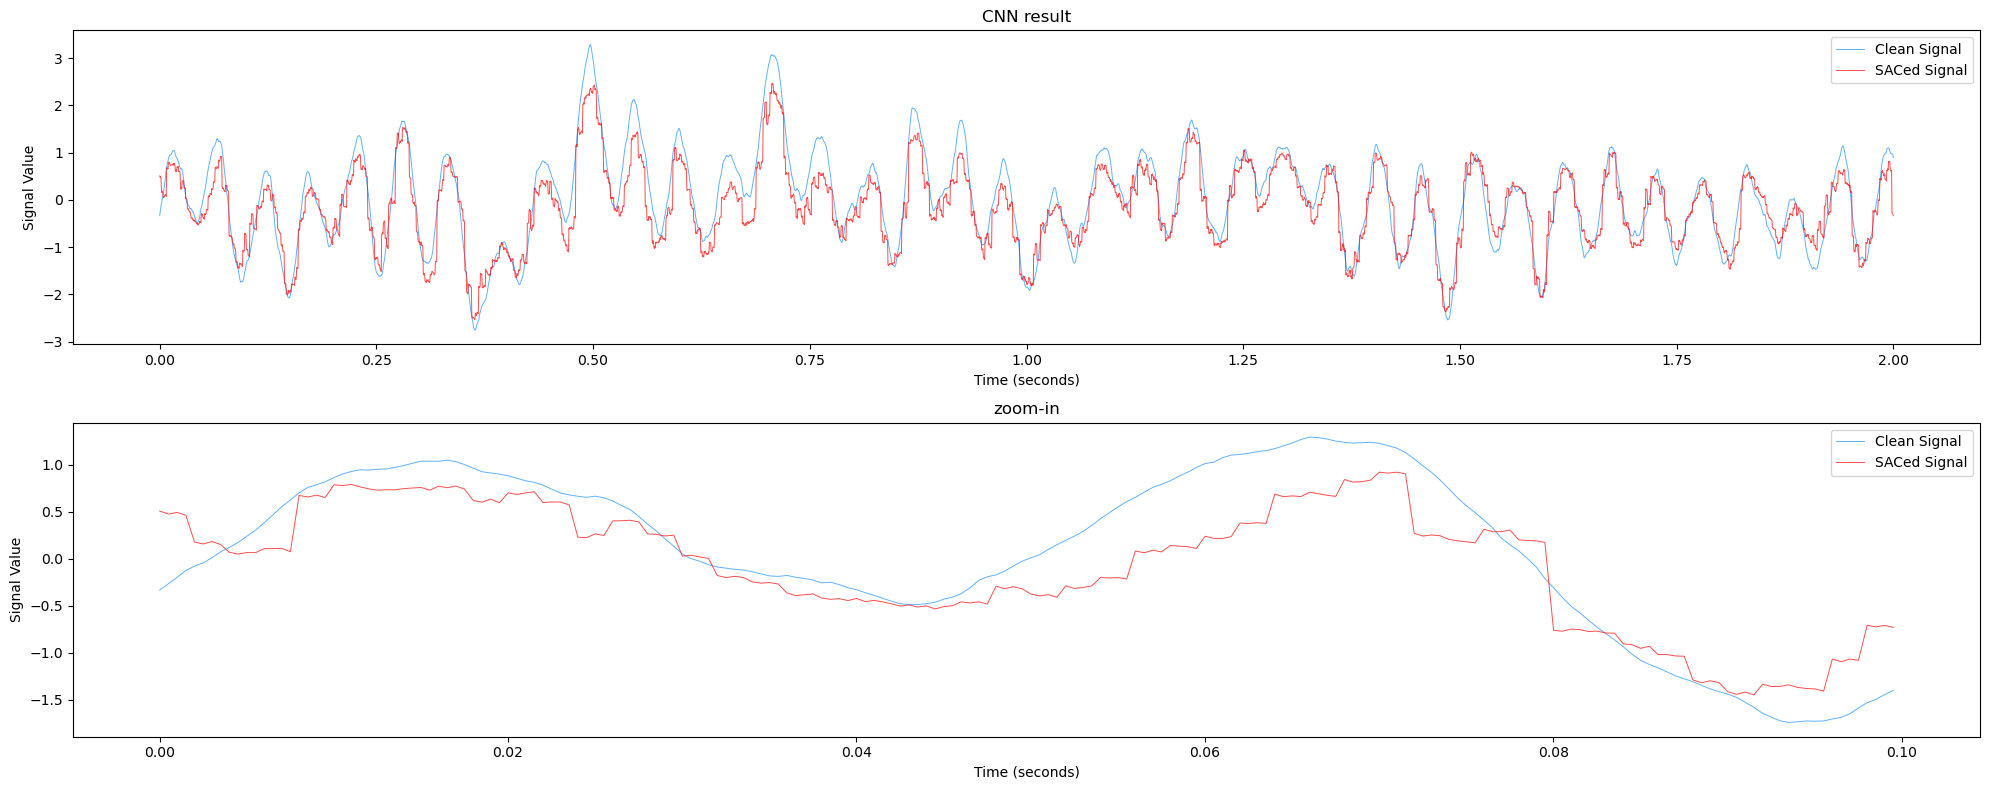

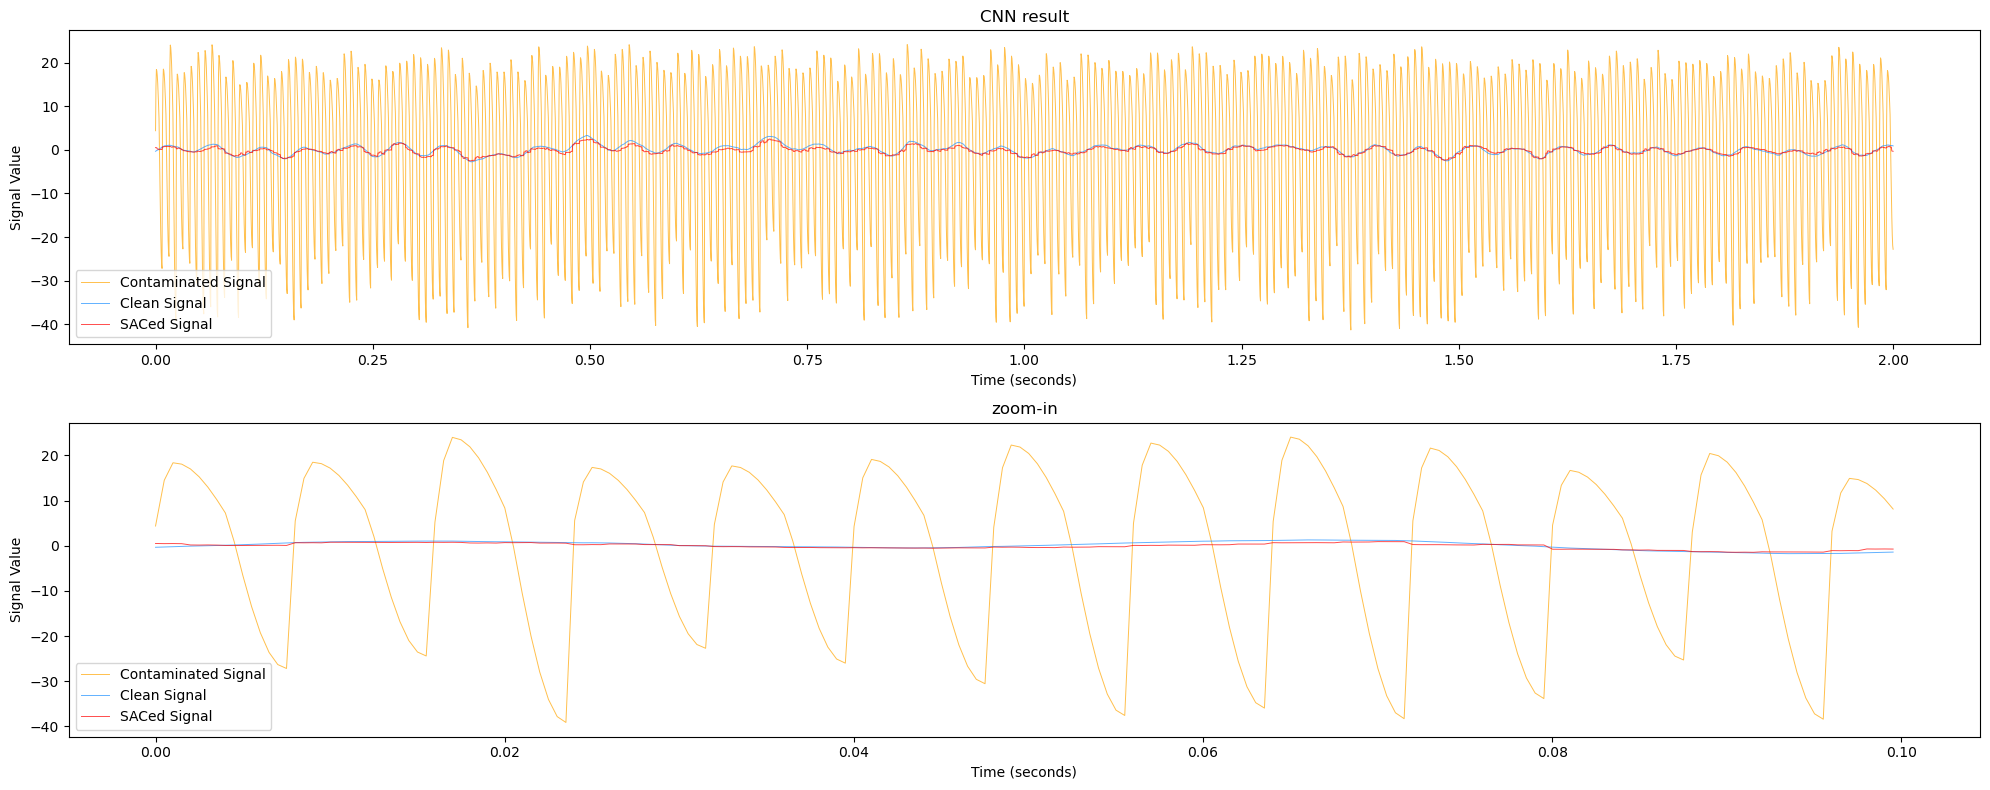

Frequency Domain Error
Mean Absolute Error: 1.0409459973781767
Mean Squared Error: 1.6679770754342718


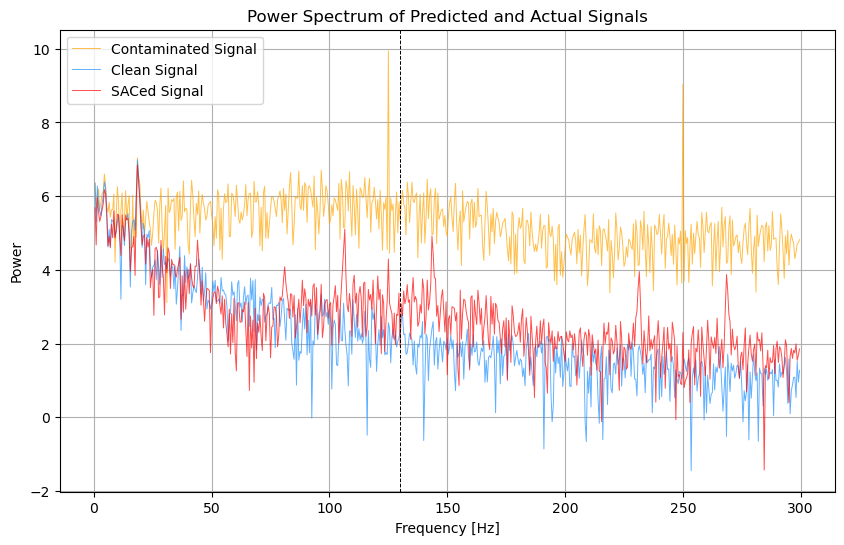

In [34]:
# time domain plotting

Contaminated_signal = pywt.imra(Contaminated[0])
SACed_signal = pywt.imra(SACed[0])
Clean_signal = pywt.imra(Clean[0])

scaled_Contaminated_signal = scaler_x.inverse_transform(Contaminated_signal.reshape(-1, 1))
scaled_Clean_signal = scaler_y.inverse_transform(Clean_signal.reshape(-1, 1))
scaled_SACed_signal = scaler_y.inverse_transform(SACed_signal.reshape(-1, 1))

from DataLoad import Result_Plot
Result_Plot(scaled_Contaminated_signal.squeeze(), scaled_SACed_signal.squeeze(), scaled_Clean_signal.squeeze()) # squeeze 하고 넣어야 함.

In [ ]:
# inverse하고 scaling 하느냐 scaling 하고 inverse하느냐. 후가 맞는 것 같은데 전으로 해도 같은 결과?

Contaminated_signal = pywt.imra(Contaminated[0])
SACed_signal = pywt.imra(SACed[0])
Clean_signal = pywt.imra(Clean[0])

print(Contaminated_signal.shape)

scaled_Contaminated = scaler_x.inverse_transform(Contaminated)

Contaminated_inverse = torch.tensor([])
SACed_inverse = torch.tensor([])
Clean_inverse = torch.tensor([])

for i in range(len(Contaminated)):
    Contaminated_inverse = torch.cat((Contaminated_inverse, pywt.imra(Contaminated[i]).reshape(1, -1).cpu()), 0)
    SACed_inverse = torch.cat((SACed_inverse, pywt.imra(SACed[i]).reshape(1, -1).cpu()), 0)
    Clean_inverse = torch.cat((Clean_inverse, pywt.imra(Clean[i]).reshape(1, -1).cpu()), 0)

print(Contaminated_inverse.shape)

scaled_Contaminated_inverse = scaler_x.inverse_transform(Contaminated_inverse)
scaled_Clean_inverse = scaler_y.inverse_transform(Clean_inverse)
scaled_SACed_inverse = scaler_y.inverse_transform(SACed_inverse)

scaled_Contaminated_signal1 = scaler_x.inverse_transform(Contaminated_signal.reshape(-1, 1))
print(f"Mean Absolute Error: {mean_absolute_error(scaled_Contaminated_signal1, scaled_Contaminated_inverse[0])}")

print(f"Mean Absolute Error: {mean_absolute_error(scaled_Contaminated_signal1, scaled_Contaminated[0])}")

print(f"Mean Absolute Error: {mean_absolute_error(Contaminated_signal, Contaminated_inverse[0])}")
print(f"Mean Absolute Error: {mean_absolute_error(SACed_signal, SACed_inverse[0])}")
print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, Clean_inverse[0])}")